In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf
#override pandas_datareader's default methods to fetch data
yf.pdr_override()
from pandas_datareader import data as pdr

stock_symbol='D05.SI'
#get 8 years of daily stock data
df = pdr.get_data_yahoo(stock_symbol, start='2014-01-01', end='2021-12-31')

[*********************100%%**********************]  1 of 1 completed


Data Exploration

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,15.636363,15.654545,15.500000,15.545454,9.610726,2033900
2014-01-03,15.518181,15.545454,15.336363,15.436363,9.543283,2733500
2014-01-06,15.436363,15.481818,15.372727,15.472727,9.565764,1372800
2014-01-07,15.518181,15.581818,15.409090,15.490909,9.577005,3883000
2014-01-08,15.581818,15.809090,15.554545,15.790909,9.762473,6241400
...,...,...,...,...,...,...
2021-12-24,29.609091,29.645454,29.518181,29.645454,25.772141,1155000
2021-12-27,29.636362,29.681818,29.545454,29.545454,25.685207,672980
2021-12-28,29.636362,29.772726,29.572727,29.772726,25.882782,1723920


In [4]:
df.shape

(2011, 6)

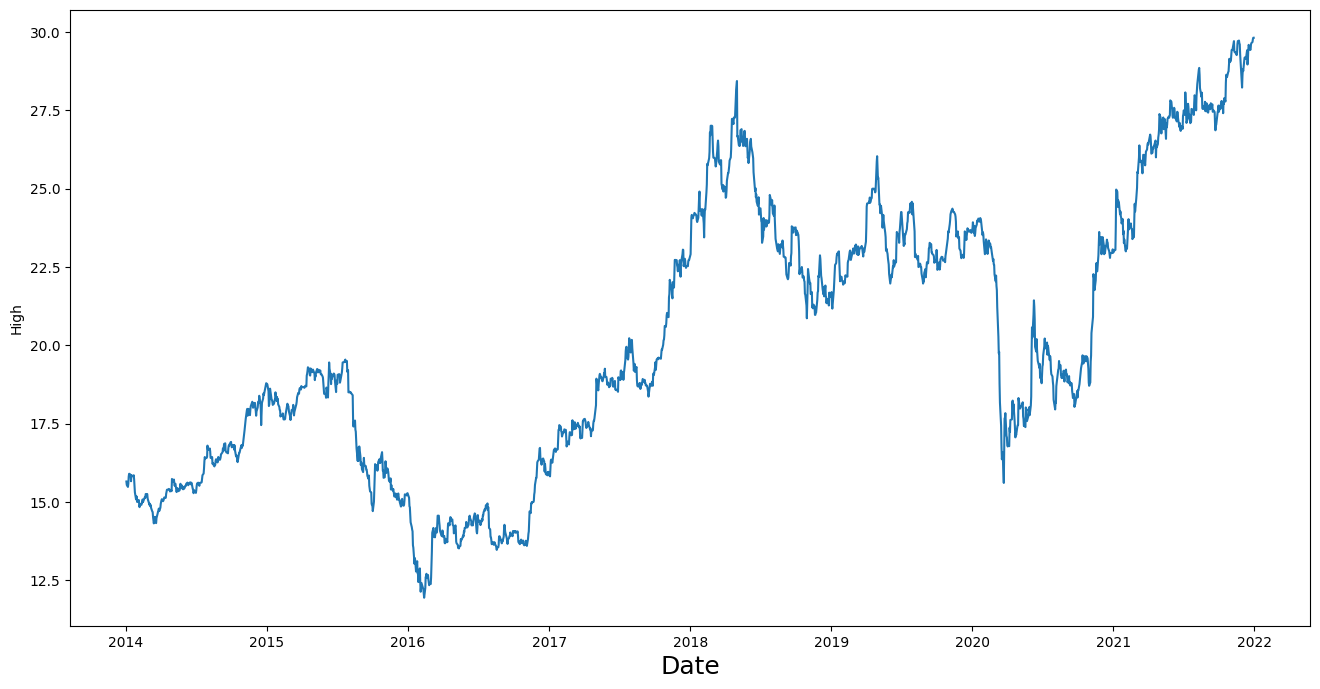

In [5]:
#plot the daily high prices to visualize trends over time
plt.figure(figsize=(16,8))
plt.plot(df[['High']])
plt.xlabel('Date', fontsize =18)
plt.ylabel('High')
plt.show()

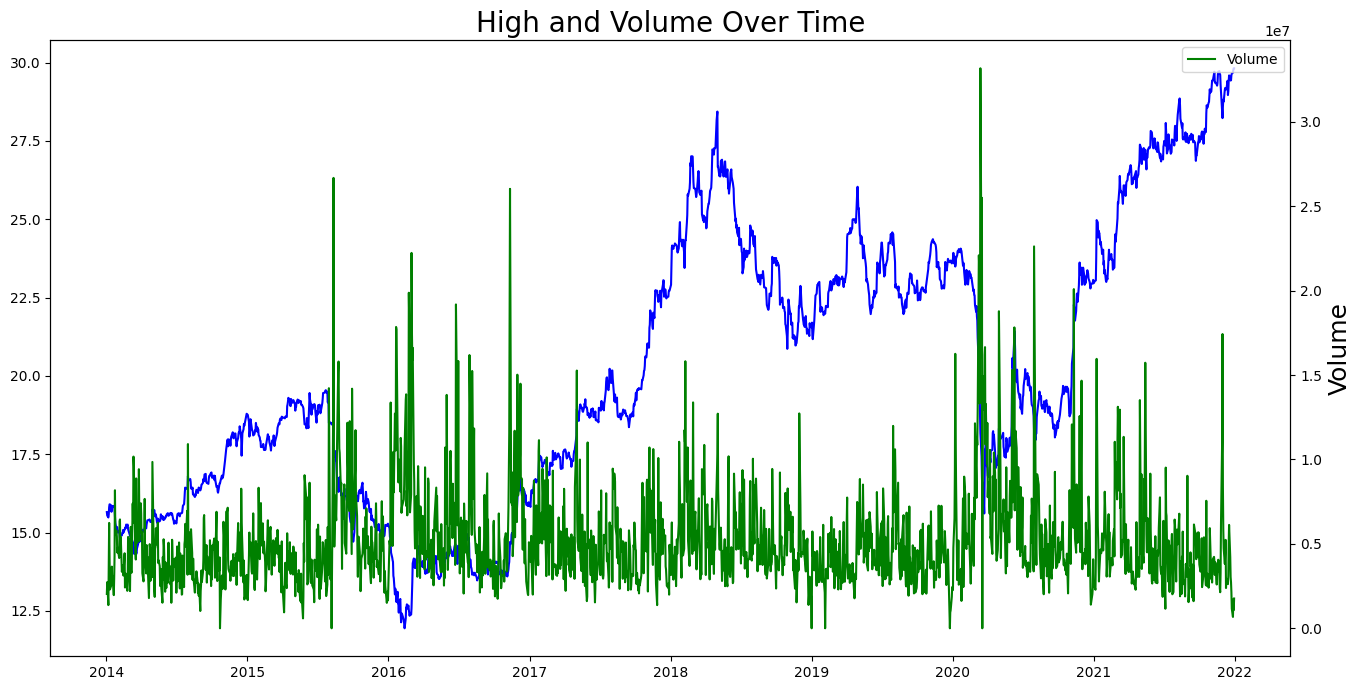

In [6]:
#plot high prices and volume on the same chart for correlation analysis 
plt.figure(figsize=(16,8))

plt.plot(df['High'], label='High', color='blue')


ax2 = plt.gca().twinx()
ax2.plot(df['Volume'], label='Volume', color='green')


plt.xlabel('Date', fontsize=18)
plt.ylabel('High', fontsize=18)
ax2.set_ylabel('Volume', fontsize=18)

plt.title('High and Volume Over Time', fontsize=20)
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Data Preprocessing

In [7]:
data = df.filter(['High','Volume'])
data_keep = df.filter(['High','Volume']).copy()

In [8]:
#scale the high and volume data for LSTM input
scaler_high = MinMaxScaler()
scaler_volume = MinMaxScaler()
scaler_high.fit(data[['High']])
scaler_volume.fit(data[['Volume']])
data['High'] = scaler_high.transform(data[['High']])
data['Volume'] = scaler_volume.transform(data[['Volume']])

In [9]:
scaled_data = data.values
scaled_data

array([[0.207528  , 0.06130108],
       [0.20142424, 0.0823868 ],
       [0.19786374, 0.04137574],
       ...,
       [0.99745679, 0.05195839],
       [1.        , 0.03244747],
       [1.        , 0.05315523]])

In [10]:
training_data_len = (len(scaled_data))
training_data_len

2011

In [11]:
train_data = scaled_data[0:training_data_len, :]
train_data

array([[0.207528  , 0.06130108],
       [0.20142424, 0.0823868 ],
       [0.19786374, 0.04137574],
       ...,
       [0.99745679, 0.05195839],
       [1.        , 0.03244747],
       [1.        , 0.05315523]])

In [12]:
train_data.shape

(2011, 2)

Model Training

In [13]:
#prepare data for LSTM model by creating sequences of 52 days for training
x_train = []
y_train = []
sequence_length = 52

for i in range(len(train_data) - sequence_length):
    x_train.append(train_data[i:i + sequence_length])
    y_train.append(train_data[i + sequence_length][0])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train

array([[[0.207528  , 0.06130108],
        [0.20142424, 0.0823868 ],
        [0.19786374, 0.04137574],
        ...,
        [0.13835202, 0.28886767],
        [0.13275688, 0.23326902],
        [0.14445578, 0.13957683]],

       [[0.20142424, 0.0823868 ],
        [0.19786374, 0.04137574],
        [0.20345883, 0.11703235],
        ...,
        [0.13275688, 0.23326902],
        [0.14445578, 0.13957683],
        [0.13936931, 0.12280108]],

       [[0.19786374, 0.04137574],
        [0.20345883, 0.11703235],
        [0.21617497, 0.18811376],
        ...,
        [0.14445578, 0.13957683],
        [0.13936931, 0.12280108],
        [0.13377417, 0.26758303]],

       ...,

       [[0.8819939 , 0.09844974],
        [0.89216693, 0.11352138],
        [0.88606318, 0.07676394],
        ...,
        [0.98779259, 0.06419871],
        [0.9903358 , 0.03481132],
        [0.99237038, 0.0202834 ]],

       [[0.89216693, 0.11352138],
        [0.88606318, 0.07676394],
        [0.9196339 , 0.22768594],
        .

In [14]:
x_train.shape

(1959, 52, 2)

In [15]:
y_train

array([0.13936931, 0.13377417, 0.13326555, ..., 0.99745679, 1.        ,
       1.        ])

In [16]:
y_train.shape

(1959,)

In [17]:
#build LSTM model architecture
model = Sequential()
model.add(InputLayer(shape=(52, 2)))
model.add(LSTM(100, dropout=0.1))
# model.add(LSTM(100, dropout= 0.1,input_shape=(52,2)))
model.add(Dense(10))
model.add(Dense(1))

In [18]:
#compile the model
model.compile(optimizer = 'adam', loss='mean_squared_error')

In [19]:
#train the model
model.fit(x_train,y_train, batch_size=16, epochs = 50)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0483
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0169
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0107
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0063
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0072
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0069
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0067
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0052
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0076
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0068
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0066
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0061
Epoch 13/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0054
Epoch 14/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0056
Epoch 15/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s

Testing and Evaluation

In [20]:
#assuming test dataset cannot take any data from the train dataset period. meaning there will be a gap of 52days
#prepare the test dataset from 2022 data
df_test = pdr.get_data_yahoo(stock_symbol, start='2022-01-01', end='2023-12-31')
df_test

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,29.818180,29.845453,29.745455,29.809090,25.914398,1771660
2022-01-04,30.045454,30.709089,30.009090,30.645454,26.641487,5813720
2022-01-05,30.727272,30.772726,30.063637,30.218182,26.270042,5120060
2022-01-06,29.981817,30.745455,29.963636,30.745455,26.728422,5170110
2022-01-07,31.045454,31.245455,30.945454,31.245455,27.163092,5531460
...,...,...,...,...,...,...
2023-12-22,28.909090,29.136362,28.863636,29.090908,28.225023,5476130
2023-12-26,29.172728,29.181818,28.954544,29.000000,28.136820,1202520
2023-12-27,29.136362,29.463636,29.027271,29.400000,28.524914,3089900


In [21]:
data_test = df_test.filter(['High','Volume'])
test_keep = df_test.filter(['High','Volume'])

In [22]:
data_test['High'] = scaler_high.transform(data_test[['High']])
data_test['Volume'] = scaler_volume.transform(data_test[['Volume']])

In [23]:
scaled_data_test = data_test.values
scaled_data_test

array([[1.00152597, 0.05339725],
       [1.04984741, 0.17522362],
       [1.05340797, 0.15431694],
       [1.05188211, 0.15582543],
       [1.07985769, 0.1667164 ],
       [1.12105804, 0.20610955],
       [1.13987793, 0.22038551],
       [1.14750766, 0.21648333],
       [1.14445594, 0.12572192],
       [1.15666324, 0.13401365],
       [1.16429297, 0.13572968],
       [1.16937959, 0.13992162],
       [1.16785352, 0.145421  ],
       [1.16225849, 0.16322863],
       [1.15462876, 0.22680737],
       [1.15513738, 0.10004443],
       [1.14242124, 0.21092015],
       [1.14445594, 0.16707446],
       [1.12970511, 0.18896581],
       [1.12207538, 0.30851452],
       [1.13987793, 0.14898251],
       [1.17243152, 0.22681732],
       [1.16225849, 0.12050685],
       [1.18718214, 0.15768535],
       [1.20651076, 0.1762547 ],
       [1.21363187, 0.10727855],
       [1.21414049, 0.12200208],
       [1.23601221, 0.2004436 ],
       [1.23855552, 0.16749219],
       [1.21007131, 0.22383017],
       [1.

In [24]:
#prepare sequences for testing the model
x_test = []
y_test = []

sequence_length = 52

for i in range(len(scaled_data_test) - sequence_length):
    x_test.append(scaled_data_test[i:i + sequence_length])
    y_test.append(scaled_data_test[i + sequence_length][0])

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test

array([[[1.00152597, 0.05339725],
        [1.04984741, 0.17522362],
        [1.05340797, 0.15431694],
        ...,
        [1.06561559, 0.21140419],
        [1.09562566, 0.172694  ],
        [1.12410986, 0.19178055]],

       [[1.04984741, 0.17522362],
        [1.05340797, 0.15431694],
        [1.05188211, 0.15582543],
        ...,
        [1.09562566, 0.172694  ],
        [1.12410986, 0.19178055],
        [1.10986787, 0.27290751]],

       [[1.05340797, 0.15431694],
        [1.05188211, 0.15582543],
        [1.07985769, 0.1667164 ],
        ...,
        [1.12410986, 0.19178055],
        [1.10986787, 0.27290751],
        [1.12207538, 0.10658564]],

       ...,

       [[1.07121062, 0.14453661],
        [1.05696852, 0.09613561],
        [1.03509669, 0.07515267],
        ...,
        [0.9526959 , 0.13005796],
        [0.96185148, 0.16504877],
        [0.9643948 , 0.03624356]],

       [[1.05696852, 0.09613561],
        [1.03509669, 0.07515267],
        [1.05289935, 0.07160855],
        .

In [25]:
x_test.shape

(447, 52, 2)

In [26]:
y_test

array([1.10986787, 1.12207538, 1.12054942, 1.13021373, 1.14445594,
       1.15208545, 1.17090545, 1.17802655, 1.17599186, 1.1765007 ,
       1.14903373, 1.14903373, 1.15869793, 1.15717207, 1.1459818 ,
       1.11698886, 1.07731449, 1.06256366, 1.05849449, 1.05086476,
       1.02644973, 1.04120045, 1.0305189 , 1.04069183, 1.04577824,
       1.05798587, 1.04069183, 1.01322486, 1.01780266, 1.0824009 ,
       1.08036631, 1.08647007, 1.02746697, 1.01882   , 0.98982707,
       0.9643948 , 0.93896242, 0.94201435, 0.9338759 , 0.93285866,
       0.92573766, 0.92166838, 0.92828086, 0.90742628, 0.89369279,
       0.9125128 , 0.92522893, 0.92624628, 0.94659214, 0.92726352,
       0.92472031, 0.92370297, 0.91403876, 0.90539169, 0.90233986,
       0.88758904, 0.87334693, 0.86266538, 0.85961345, 0.86520859,
       0.88504583, 0.86419135, 0.86368273, 0.87232969, 0.88402859,
       0.87639886, 0.85757886, 0.87080373, 0.87029511, 0.87436428,
       0.86520859, 0.84486273, 0.86368273, 0.86775179, 0.87385

In [27]:
y_test.shape

(447,)

In [28]:
#make predictions and evaluate the model
predictions = model.predict(x_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [29]:
predictions.shape

(447, 1)

In [30]:
inverse_predictions = scaler_high.inverse_transform(predictions)

In [31]:
len(inverse_predictions)

447

In [32]:
rmse=np.sqrt(np.mean(((inverse_predictions- y_test)**2)))
rmse

27.379783858029953

In [33]:
#plot predictions against actual values
valid = test_keep[52:].copy()
valid['Predictions'] = inverse_predictions
valid

,High,Volume,Predictions
Date,,,
2022-03-18,31.781818,9054760,30.094355
2022-03-21,32.000000,3536390,29.836639
2022-03-22,31.972727,2891790,30.074158
2022-03-23,32.145454,3071530,30.032486
2022-03-24,32.400002,3315620,30.160181
...,...,...,...
2023-12-22,29.136362,5476130,27.340990
2023-12-26,29.181818,1202520,27.489649
2023-12-27,29.463636,3089900,27.565844


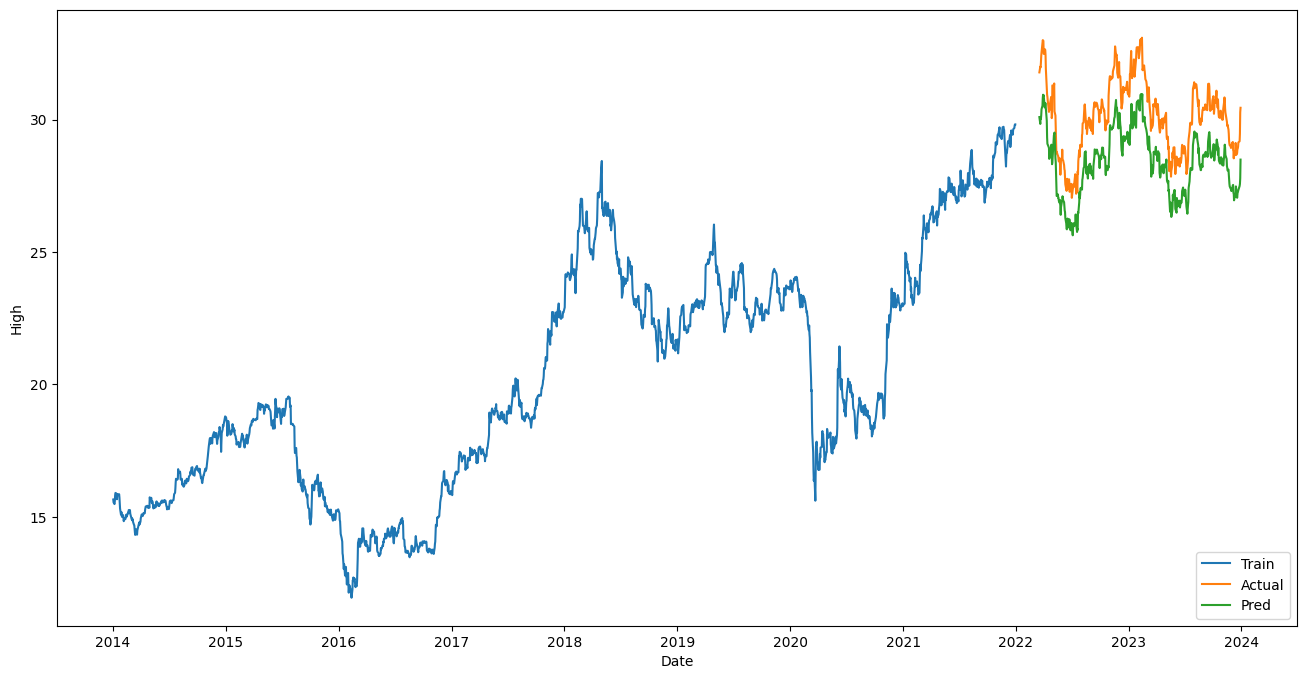

In [34]:
plt.figure(figsize = (16,8))
plt.xlabel('Date')
plt.ylabel('High')
plt.plot(df['High'])
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Train','Actual','Pred'], loc = 'lower right')
plt.show()

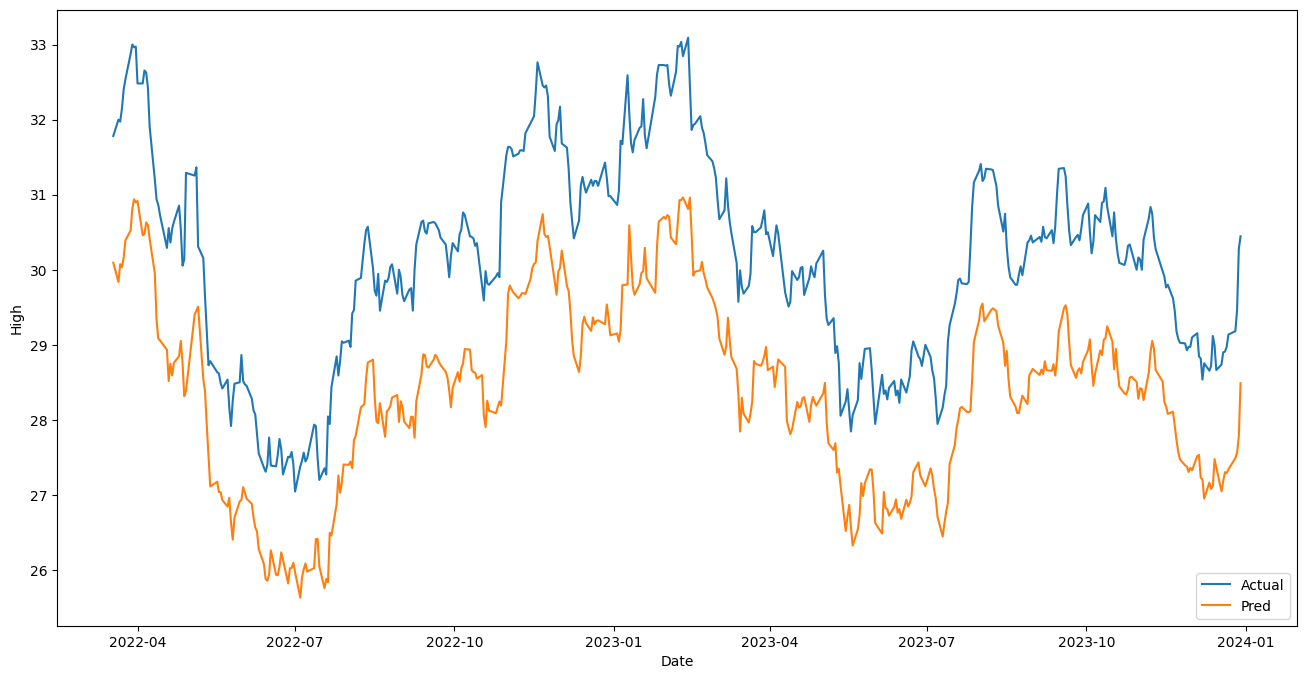

In [35]:
plt.figure(figsize = (16,8))
plt.xlabel('Date')
plt.ylabel('High')
plt.plot(valid[['High', 'Predictions']])
plt.legend(['Actual','Pred'], loc = 'lower right')
plt.show()